# **Sequence-to-Sequence Learning with RNNs**

In this tutorial, we will introduce a popular [RNN-based encoder-decoder](https://arxiv.org/abs/1409.0473) architecture for sequence-to-sequence learning.


This model has an encoder that takes in input a sequence (e.g., text, audio) and turns it into a sequence of latent representations. The decoder uses these latent representations to derive the output sequence (e.g., translated text, recognized text from speech). An attention mechanism dynamically connects encoder and decoder states.

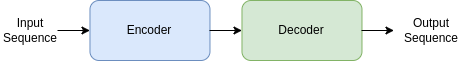

This model is very versatile, and we can use them for many tasks, including machine translation,  speech recognition, text summarization, dialogue, and many others.

Here,  we will employ it on a toy task called *sequence replay*.

**Suggestion:** when you implement a new model, a good practice is to test it on toy tasks first to ensure it behaves as expected.

Let's first describe the *sequence replay* and generate some synthetic data.

In [ ]:
import torch
import copy
torch.manual_seed(1)

## **1. The Sequence Replay Task**
As mentioned, we will use a simple toy task that will help us familiarize ourselves with sequence-to-sequence learning and attention mechanisms.

Basically, we read the inputs with a model (called "encoder"). We then ask another model (called "decoder") to replay the inputs (in the same order). We will use binary inputs only (i.e., our input sequence is composed of 0s or 1s only).

We can create artificial data for this task with the following function:

In [ ]:
def data_generation(L, N, D=1, prob=0.05):
  """This function generates random sequences of 0 and 1.

  Arguments
  ---------
  L : int
    Lenght of the sequences.
  N: int
    Number of examples.
  D: int
    Number of output features.
  prob: float:
    Probability to draw a 1.

  Returns
  ---------
  X: torch.Tensor
    Tensor of dimensionality (L,N,D) containing
    the generated sequences.
  """
  X = torch.bernoulli(torch.full((N, L, D), prob)).float()
  return X

We generate 1000 sequences of 16 elements for training and 500 for test:

In [ ]:
L = 16 # sequence length
N = 1000 # number of examples
D = 1 # output features

X_train = data_generation(L, N, D=1, prob=0.5)
X_test = data_generation(L, 500, D=1, prob=0.5)

print(X_train.shape)
print(X_test.shape)

torch.Size([1000, 16, 1])
torch.Size([500, 16, 1])


We have to set `prob=0.5` to approximatively have the same number of zeros and ones in the sequences.

# **2. Sequence-to-Sequence Learning with RNNs**

Different architectures can be applied here.
We start with a basic one that uses vanilla RNNs for encoding and decoding without any attention mechanisms.

##**2.1 RNN without Attention**
In the figure below, we show how we can implement the aforementioned system for the sequence replay task.

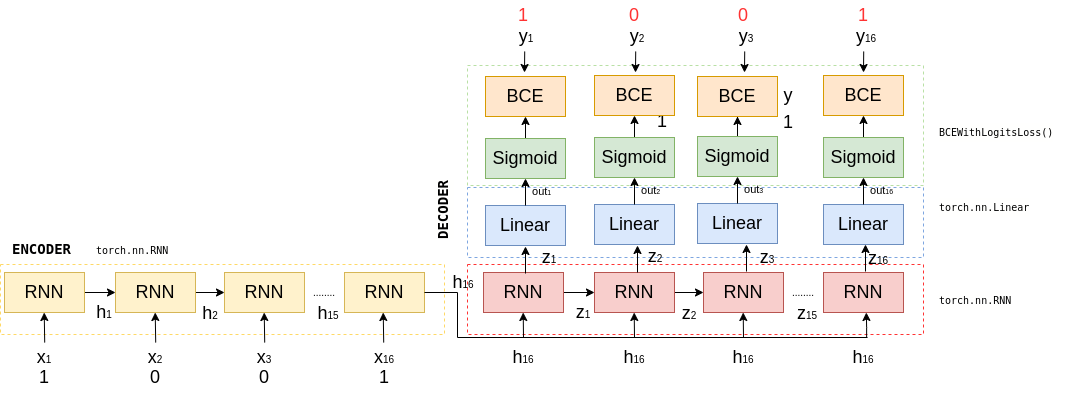

The encoder receives in input a sequence of L elements (for instance, $\mathbf{x} = [0,0,1,1,0,0,0,1,1,1]$). The encoder processes it and outputs the latent representations $\mathbf{H}=[\mathbf{h}_1, \mathbf{h}_2, ..., \mathbf{h}_L]^T$.

We will start with a simple decoder that takes in input the last hidden state $\mathbf{h}_L$ only and has to regenerate $\mathbf{x} = [0,0,1,1,0,0,0,1,1,1]$ in output.

We can feed $\mathbf{h}_L$ into all the decoder inputs. On top of each decoded hidden state, we can apply a binary classifier.


We are now ready to implement the model described above:

In [ ]:
class EncoderDecoderRNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=8, num_layers=1):
    super(EncoderDecoderRNN, self).__init__()

    # Store info needed in the forward step
    self.hidden_size=hidden_size
    self.num_layers=num_layers

    # Encoder initialization
    self.encoder = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    # Decoder initialization
    self.decoder = torch.nn.RNN(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    # Linear initialization
    self.linear = torch.nn.Linear(in_features=hidden_size, out_features=1)


  def forward(self, X):
    """This function encodes the input sequences with an RNN. A decoder is fed with
    the last encoded state and generates an output sequence with the same length
    of the input one.

    Arguments
    ---------
    X : torch.Tensor
      Tensor containing the sequences (N, L, 1).

    Returns
    ---------
    out: torch.Tensor
      Tensor (N,L,1) containing the logits for each decoded output.
    """
    # Run the RNN encoder
    H, _ = self.encoder(X)

    # Select the last hidden state
    hL = H[:,-1:,:]

    # Run the decoding steps
    # This loop can be avoided in this specific case. We implemented this system
    # in this way just because it will be easier to add attention.
    zt = torch.zeros(self.num_layers, X.shape[0], self.hidden_size, device=X.device) #[ Number of layer in the decoder, Batch size, Number of hidden units ]
    Z = []
    for i in range(X.shape[1]): #is going to run until the batch size
    # The decoder is only influenced by the encoder's last hidden state (hL) and its own previous hidden states (zt).
    # The encoder’s intermediate hidden states (H) are not used in the decoding process.

      z, zt = self.decoder(hL,zt) # call the decoder using th encoder's last state, and new decoder state
      Z.append(z) # update the new
    Z = torch.cat(Z, dim=1) # (batch_size, sequence_length, hidden_size)

    # Run the linear transformation
    out = self.linear(Z)

    if not (self.training):
      # Apply the sigmoid and a threshold on it.
      out = (torch.sigmoid(out) > 0.5).int()

    return out, _


Now, we can train the model:

In [ ]:
def training_loop(X, y, model, loss, optimizer, num_epoch=500, batch_size=100, epoch_check=50):

  # Getting the number of input samples
  N = X.shape[0]

  # Initializing best loss
  best_loss = float('inf')
  best_model = copy.deepcopy(model)

  # Training Loop
  for epoch in range(num_epoch):
    for i in range(0, N, batch_size):

      # Minibatch selection (on X and y)
      # Your code here. Aim for 2 lines
      Xi = X[i:i+batch_size, :, :]
      yi = y[i:i+batch_size, :, :]

      # Run Model
      logits, _ = model(Xi)

      # Compute the losse
      l = loss(logits, yi)

      # Update the parameters
      model.zero_grad()
      l.backward()

      # Gradient clipping help improving training stability
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
      optimizer.step()

    # Print the training loss
    if (epoch + 1) % epoch_check == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))

        # Saving best model
        if l.item() <= best_loss:
          best_loss = l.item()
          best_model = copy.deepcopy(model)

  return best_model

In [ ]:
# Hyperparameters
num_epoch = 650
batch_size = 50
lr = 0.004
hidden_size = 15
num_layers= 1

# Initialization
model = EncoderDecoderRNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Run the training loop
best_model = training_loop(X_train, X_train, model, loss, optimizer, num_epoch, batch_size)

Epoch 050: Train_loss: 0.5464 
Epoch 100: Train_loss: 0.4056 
Epoch 150: Train_loss: 0.2535 
Epoch 200: Train_loss: 0.0304 
Epoch 250: Train_loss: 0.0085 
Epoch 300: Train_loss: 0.0041 
Epoch 350: Train_loss: 0.0011 
Epoch 400: Train_loss: 0.0051 
Epoch 450: Train_loss: 0.0061 
Epoch 500: Train_loss: 0.0021 
Epoch 550: Train_loss: 0.0030 
Epoch 600: Train_loss: 0.0143 
Epoch 650: Train_loss: 0.0116 


Let's now test the model on unseen sequences:

In [ ]:
# Put the model in eval mode
best_model.eval()

# Run the model
out, _ = best_model(X_test)

# Compute Test Error
err = (out!=X_test).sum()/X_test.numel()

print("Test Error: %.2f%%" %(err*100))
print(out[0,:].transpose(0,1))
print(X_test[0,:].int().transpose(0,1))


NameError: name 'best_model' is not defined

As an optional exercise, try to see what happens when increasing the sequence length $L$.
You will see that a Vanilla RNN will struggle to remember long sequences of elements.

This simple system works decently well for this toy task. However, it won't work well in real tasks such as machine translation or speech recognition.

*Could you guess why?*

The decoder uses only the last hidden state of the encoder to replay the input sequence.

The last encoded state depends on the whole sequence, and we thus hope it will contain all the information we want. In practice, however, storing long sequences into a fixed-size representation doesn't work well, especially if the input sequence is long. The last encoded state will depend more heavily on the most recent elements and tends to forget older ones.

A solution to this problem is called "attention" and will be discussed in the following section.


##**2.2 RNN with Attention**

Attention mechanisms are a way to add dynamic connections to your architecture.
These connections are not "hard-coded" but are learned and depend on the input and status of the model.

To mitigate the problem mentioned in the previous section, we can add dynamic connections between the decoder and the encoder. In particular, at each decoding step, we might want to pick up a weighted sum of all the encoded steps rather than taking the last one by default.

That sounds like a good idea, right? But how can we learn the weights to assign to the encoded states?

We can use a neural network (e.g., a simple MLP) that we jointly learn with the encoder and the decoder RNN. This type of attention was proposed by D. Bahdanau in this [paper](https://arxiv.org/abs/1409.0473). It works well in practice and was the dominant type of attention before the advent of Transformers.

This is an encoder-decoder system with Bahdanau's attention for our sequence replay task:


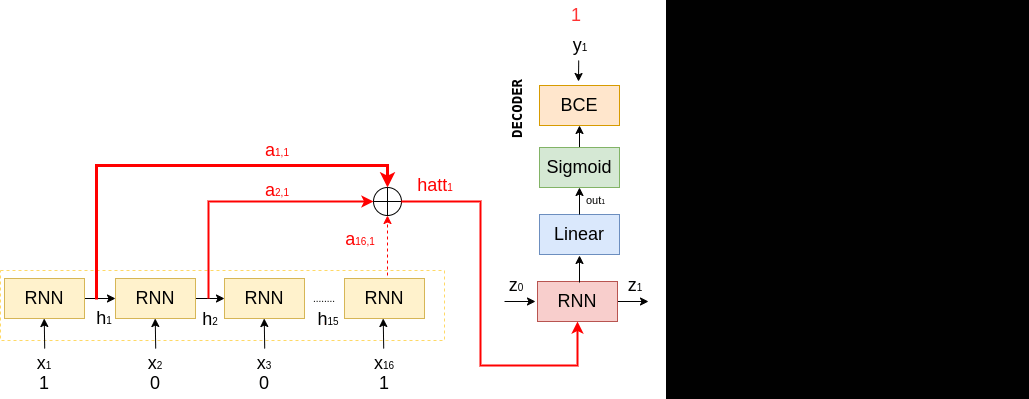

Let's now implement it:

In [ ]:
class AttentionMLP(torch.nn.Module):
    def __init__(self, hidden_size_enc, hidden_size_dec, hidden_size):
        super(AttentionMLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(hidden_size_enc+hidden_size_dec, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1, bias=False)
        )

    def forward(self, h, zt):
        zt = torch.cat([zt]*h.shape[1], dim=1)
        x = torch.cat([zt, h],dim=2)
        x = self.layers(x)
        att_w = torch.nn.functional.softmax(x, dim=1)
        return att_w

class EncoderDecoderRNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=8, num_layers=1):
    super(EncoderDecoderRNN, self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers

    # Encoder initialization
    self.encoder = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    # Decoder initialization
    self.decoder = torch.nn.RNN(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    # Linear initialization
    self.linear = torch.nn.Linear(in_features=hidden_size, out_features=1)

    # Attention MLP
    self.attMLP = AttentionMLP(hidden_size, hidden_size, hidden_size)


  def forward(self, X):

    # Run the RNN encoder
    H, _ = self.encoder(X)

    # Run the decoding steps
    zt = torch.zeros(self.num_layers, X.shape[0], self.hidden_size, device=X.device)
    Z = []
    att_weights = []

    for i in range(X.shape[1]):

      # Compute the attention weights
      att_w = self.attMLP(H,zt[-1].unsqueeze(1))

      # Compute the weighted average of the encoding states
      h_att = torch.matmul(att_w.transpose(1,-1), H)

      # Getting the new decoding state
      z, zt = self.decoder(h_att,zt)

      # Storing the states and attention
      Z.append(z)
      att_weights.append(att_w)

    Z = torch.cat(Z, dim=1)
    att_weights = torch.cat(att_weights, dim=2)

    # Run the linear transformation
    out = self.linear(Z)

    if not(self.training):
      # Apply the sigmoid and a threshold on it.
      out = (torch.sigmoid(out) > 0.5).int()

    return out, att_weights

Let's train our model:

In [ ]:
# Hyperparameters
num_epoch = 650
batch_size = 50
lr = 0.004
hidden_size = 15
num_layers= 1

# Initialization
model = EncoderDecoderRNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Run the training loop
best_model = training_loop(X_train, X_train, model, loss, optimizer, num_epoch, batch_size)

Epoch 050: Train_loss: 0.3289 
Epoch 100: Train_loss: 0.2633 
Epoch 150: Train_loss: 0.1051 
Epoch 200: Train_loss: 0.0777 
Epoch 250: Train_loss: 0.0747 
Epoch 300: Train_loss: 0.0573 
Epoch 350: Train_loss: 0.0224 
Epoch 400: Train_loss: 0.1862 
Epoch 450: Train_loss: 0.0452 
Epoch 500: Train_loss: 0.0072 
Epoch 550: Train_loss: 0.1501 
Epoch 600: Train_loss: 0.0949 
Epoch 650: Train_loss: 0.0196 


In some cases, training might be a bit "turbolent", but  you should see a low training loss (which is zero or close to zero) for the best model. If this is not the case, re-run the code cell above (it will reinitialize the network and start training again).


Let's evaluate it and show the attention weights:

Test Error: 0.037500
tensor([[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]], dtype=torch.int32)
tensor([[1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.]])


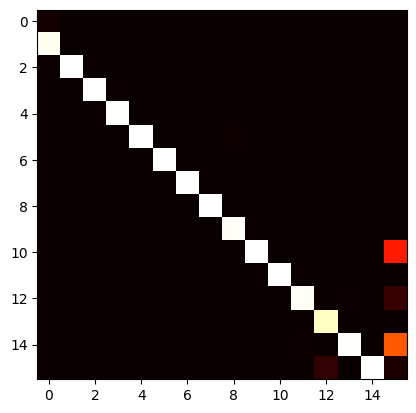

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Put the model in eval mode
best_model.eval()

# Run the model
out, att_weights = best_model(X_test)

# Compute Test Error
err = (out!=X_test).sum()/X_test.numel()

# Print Test Error
print("Test Error: %f" %(err*100))
print(out[0,:].transpose(0,1))
print(X_test[0,:].transpose(0,1))

# Plot Attention
plt.imshow(att_weights[0].detach().cpu().numpy(),cmap='hot', interpolation='nearest')
plt.show()

You should see a diagonal trend in the attention matrix. Note the RNNs have some memory ability. This means, for instance, that the encoding state $h_{10}$ can keep the information of input $x_1,..x_{10}$.

In some cases, the solution that the network discovers is to not look at $h_{10}$ when decoding the 10th element, but look at any previous one (typically the closest ones). In other words, the diagonal that emerges from the attention might be a bit shifted. Try to run training multiple times on different data to see the different solutions.

*What happens if we ask the network to output inputs in the reverse order (i.e., from the last one to the first one)?*

Let's train a system by reversing the targets:

In [ ]:
# Hyperparameters
num_epoch = 650
batch_size = 50
lr = 0.004
hidden_size = 15
num_layers= 1

# Initialization
model = EncoderDecoderRNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Run the training loop
Y_train = torch.flip(X_train, dims=(1,))
best_model = training_loop(X_train, Y_train, model, loss, optimizer, num_epoch, batch_size)

Epoch 050: Train_loss: 0.5278 
Epoch 100: Train_loss: 0.3979 
Epoch 150: Train_loss: 0.1521 
Epoch 200: Train_loss: 0.0001 
Epoch 250: Train_loss: 0.0000 
Epoch 300: Train_loss: 0.0000 
Epoch 350: Train_loss: 0.0000 
Epoch 400: Train_loss: 0.0000 
Epoch 450: Train_loss: 0.0000 
Epoch 500: Train_loss: 0.0000 
Epoch 550: Train_loss: 0.0000 
Epoch 600: Train_loss: 0.0000 
Epoch 650: Train_loss: 0.0000 


Let's plot the attention weights:

Test Error: 0.000000
tensor([[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]], dtype=torch.int32)
tensor([[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]], dtype=torch.int32)


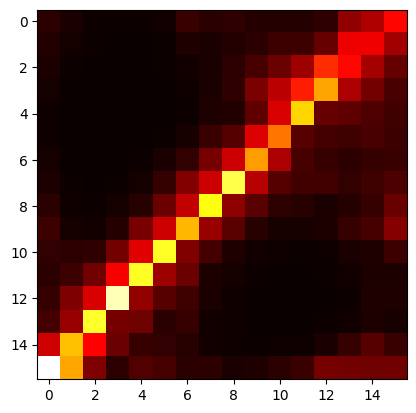

In [ ]:
# Put the model in eval mode
best_model.eval()

# Run the model
out, att_weights = best_model(X_test)

# Compute Test Error
err = (out!=X_test.flip(dims=(1,))).sum()/X_test.numel()

# Print Test Error
print("Test Error: %f" %(err*100))
print(out[0,:].transpose(0,1))
print(X_test[0,:].flip(dims=(0,)).int().transpose(0,1))

# Plot Attention
plt.imshow(att_weights[0].detach().numpy(),cmap='hot', interpolation='nearest')
plt.show()

*Did you notice something?*

The diagonal trend is now pointing in the other direction because of the reversed output.

The attention mechanism is a game changer for sequence-to-sequence learning. Let's compare the accuracy of the sequence replay task with variable sequence lengths:

|         | L=4  | L=8  | L=16 | L=32  |
|---------|------|------|------|-------|
| RNN     | 0.00% | 0.00% | 0.06% | 43.46% |
| RNN+Att | 0.00% | 0.00% | 0.00% | 2.80%   |  

Thanks to the attention mechanism, the performance is good even for long sequences. This improvement is due to the dynamic connections that make learning long-term dependencies between the encoder and decoder easier.